# Pre-employment coursework
## Exercise 4 - U-Net Autoencoder

- **Author:** Jan Xu
- **Model:** An encoder-decoder network with skip connections, forming a U-Net infrastructure.
- **Aim:** Model should be trained such that its output is a reconstruction of the input.

In [1]:
# Imports
from collections import OrderedDict

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

import torchvision
from torchvision.transforms import transforms

from utils import *

print(torch.__version__)
print(torchvision.__version__)

1.3.0
0.4.1


## Load the CIFAR-10 dataset

In [2]:
# Define transform
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

CIFAR_set = torchvision.datasets.CIFAR10(root='../data/CIFAR10', train=True,
                                         download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='../data/CIFAR10', train=False,
                                        download=True, transform=transform)

train_set, val_set = train_val_split(CIFAR_set, 0.1)

Files already downloaded and verified
Files already downloaded and verified


Original images:


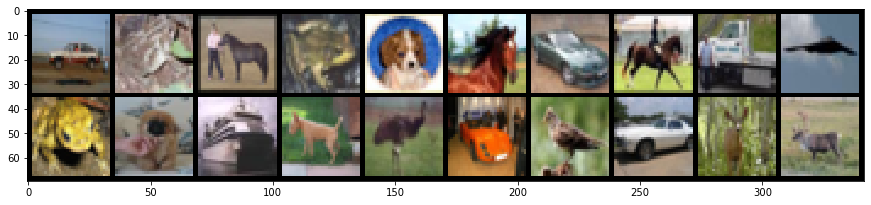

Noisy images:


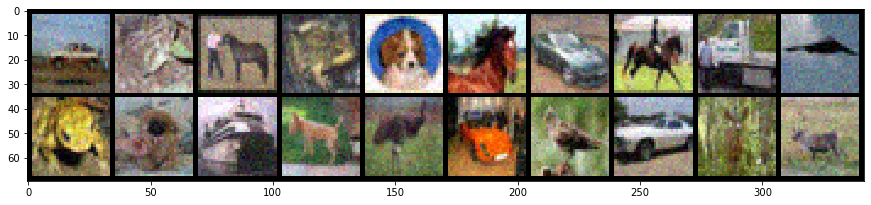

In [3]:
train_loader = DataLoader(train_set, 20)
images, _ = next(iter(train_loader))
print("Original images:")
imgviz(images)
print("Noisy images:")
imgviz(image_noiser(images, std=0.1))

## Define model

In [4]:
class Block(nn.Module):
    """
    U-Net block, consisting mainly of three convolutional filters with
    batch normalisation and ReLU activation functions.
    
    'down' blocks downsample at the output layer and outputs both downsampled
    and non-downsampled activations.
    
    'up' blocks concatenate non-downsampled corresponding feature maps and
    upsample at the output layer.
    
    'out' blocks concatenate non-downsampled corresponding feature maps and
    outputs the final feature maps, representing the final output layer of
    the model.
    """
    
    def __init__(self, in_channels, out_channels, direction='down'):
        assert direction in ['down', 'up', 'out'], "Direction must be either 'down', 'up' or 'out'."
        super(Block, self).__init__()
        if direction == 'down':
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
            self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
            self.out = nn.Conv2d(out_channels, out_channels, 2, 2, 0)
        else:
            self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, 3, 1, 1)
            self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, 3, 1, 1)
            if direction == 'up':
                self.out = nn.ConvTranspose2d(out_channels, out_channels // 2, 2, 2, 0)
            elif direction == 'out':
                self.out = nn.ConvTranspose2d(out_channels, 3, 1, 1, 0)
            
        self.BN1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.BN2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        self.direction = direction
    
    def forward(self, inputs, cat_layers=None):
        if self.direction != 'down':
            assert cat_layers is not None, "'up' and 'out' directions must have concatenated layers."
            assert inputs.shape == cat_layers.shape, "Shape of both inputs and concatenated layers must be equal."
            inputs = torch.cat((inputs, cat_layers), dim=1)
        
        conv1 = self.conv1(inputs)
        BN1 = self.BN1(conv1)
        relu1 = self.relu1(BN1)
        conv2 = self.conv2(relu1)
        BN2 = self.BN2(conv2)
        relu2 = self.relu2(BN2)
        out = self.out(relu2)
        if self.direction == 'down':
            return out, relu2
        else:
            return out

In [5]:
class Encoder(nn.Module):
    """
    Encoder class, consists of three 'down' blocks.
    """
    
    def __init__(self):
        super(Encoder, self).__init__()
        self.block1 = Block(3, 16, 'down')
        self.block2 = Block(16, 32, 'down')
        self.block3 = Block(32, 64, 'down')
    
    def forward(self, inputs):
        block1, concat1 = self.block1(inputs)
        block2, concat2 = self.block2(block1)
        block3, concat3 = self.block3(block2)
        concats = [concat1, concat2, concat3]
        return block3, concats

In [6]:
class Decoder(nn.Module):
    """
    Decoder class, consists of two 'up' blocks and a final 'out' block.
    """
    
    def __init__(self):
        super(Decoder, self).__init__()
        self.block1 = Block(128, 64, 'up')
        self.block2 = Block(64, 32, 'up')
        self.block3 = Block(32, 16, 'out')
    
    def forward(self, inputs, concats):
        block1 = self.block1(inputs, concats[-1])
        block2 = self.block2(block1, concats[-2])
        block3 = self.block3(block2, concats[-3])
        return block3

In [7]:
class Autoencoder(nn.Module):
    """
    Autoencoder class, combines encoder and decoder model with a bottleneck
    layer in between.
    """
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, 2, 0)
        )
    
    @property
    def num_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        num_p = sum([np.prod(p.size()) for p in model_parameters])
        return num_p
    
    def forward(self, inputs):
        encoded, concatted = self.encoder(inputs)
        bottlenecked = self.bottleneck(encoded)
        decoded = self.decoder(bottlenecked, concatted)
        added = inputs + decoded
        return added

In [8]:
print("Number of parameters in model: {0}".format(Autoencoder().num_params))

Number of parameters in model: 505091


## Training

In [9]:
param_names = ('init_lr', 'batch_size', 'weight_decay')
parameters = OrderedDict(
    run = [0.005, 256, 0.0001]
)

In [10]:
m = RunManager()
num_epochs = 120
noise_std = 0.1

for hparams in RunBuilder.get_runs_from_params(param_names, parameters):

    # Instantiate a network model
    ae = Autoencoder()

    # Construct a DataLoader object with training data
    train_loader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=hparams.batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=10, shuffle=False)
    test_images, _ = next(iter(test_loader))
    test_noisy_images = image_noiser(test_images)

    # Define optimizer
    optimizer = optim.SGD(ae.parameters(), lr=hparams.init_lr, momentum=0.9, weight_decay=hparams.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 50, 0.1)
    
    # Setup run instance
    m.begin_run(hparams, ae, test_images, test_noisy_images)
    print('Now training model with hyperparameters: init_lr={0}, batch_size={1}, weight_decay={2}'
         .format(hparams.init_lr, hparams.batch_size, hparams.weight_decay))
    
    # Start training loop
    for epoch in range(num_epochs):
        m.begin_epoch()
        
        # Train the model
        for i, batch in enumerate(train_loader):
            images, _ = batch
            noisy_images = image_noiser(images)
            
            # Zero all gradients
            optimizer.zero_grad()

            # Calculating the loss
            preds = ae(noisy_images)
            loss = F.mse_loss(preds, images)
            
            if i % 10 == 0:
                with torch.no_grad():
                    val_images, _ = next(iter(val_loader))
                    val_noisy_images = image_noiser(val_images)
                    val_preds = ae(val_noisy_images)
                    val_loss = F.mse_loss(val_preds, val_images)
                    m.track_loss(val_loss, val_images.size(0), mode='val')
                print('Epoch {0}, iteration {1}: train loss {2}, val loss {3}'.format(epoch+1,
                                                                               i*hparams.batch_size,
                                                                               round(loss.item(), 6),
                                                                               round(val_loss.item(), 6)))
            
            # Backpropagate
            loss.backward()

            # Update the weights
            optimizer.step()
            
            m.track_loss(loss, images.size(0), mode='train')
            
        m.end_epoch()
    
    #torch.save(ae, './models/' + str(hparams) + '.pth')
    m.end_run()
    print("Model has finished training.\n")
    scheduler.step()
    
m.save('results_final')
print("Training completed.")

,run,epoch,train loss,validation loss,epoch duration,run duration,init_lr,batch_size,weight_decay
0,1,1,0.050748,0.072139,502.305967,506.106357,0.005,256,0.0001
1,1,2,0.011923,0.011934,441.542033,948.124581,0.005,256,0.0001
2,1,3,0.011054,0.011047,458.433921,1407.009011,0.005,256,0.0001
3,1,4,0.010621,0.010611,453.769800,1861.251279,0.005,256,0.0001
4,1,5,0.010353,0.010330,470.848901,2332.626727,0.005,256,0.0001
5,1,6,0.010158,0.010145,458.011807,2791.130820,0.005,256,0.0001
6,1,7,0.010007,0.009986,455.926895,3247.528702,0.005,256,0.0001
7,1,8,0.009886,0.009869,469.956921,3718.212041,0.005,256,0.0001
8,1,9,0.009784,0.009765,462.294833,4180.964806,0.005,256,0.0001
9,1,10,0.009691,0.009682,469.039059,4650.483494,0.005,256,0.0001


Model has finished training.

Training completed.


<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

## Evaluate model performance

In [17]:
# Load best model
ae = torch.load('./models/final_best_Run(init_lr=0.005, batch_size=256, weight_decay=0.0001).pth')

Visualising test images...

Original images:


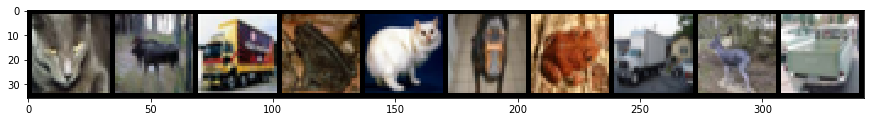

Noisy images:


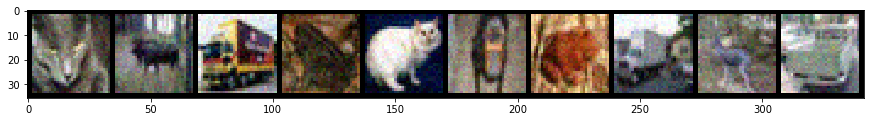

Reconstructed images:


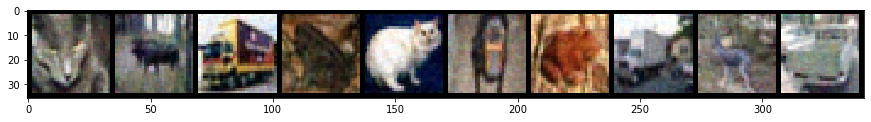

Test loss: 0.0045237429440021515


In [11]:
print("Visualising test images...\n")

test_loader = DataLoader(test_set, batch_size=10, shuffle=True)
images, _ = next(iter(test_loader))
noisy_images = image_noiser(images)
print("Original images:")
imgviz(images)
print("Noisy images:")
imgviz(noisy_images)
print("Reconstructed images:")
with torch.no_grad():
    preds = ae(noisy_images)
    imgviz(preds)

# Test loss
test_loader = DataLoader(test_set, batch_size=len(test_set))
for i, batch in enumerate(test_loader):
    images, _ = batch
    noisy_images = image_noiser(images)
    with torch.no_grad():
        preds = ae(noisy_images)
        loss = F.mse_loss(preds, images) # calculates the loss
print('Test loss:', loss.item())

## Validate with Kodak image dataset

In [12]:
transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(256),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

kodak_set = torchvision.datasets.ImageFolder(root='../data/Kodak', transform=transform)
kodak_loader = DataLoader(kodak_set, batch_size=24)

Original Kodak images:


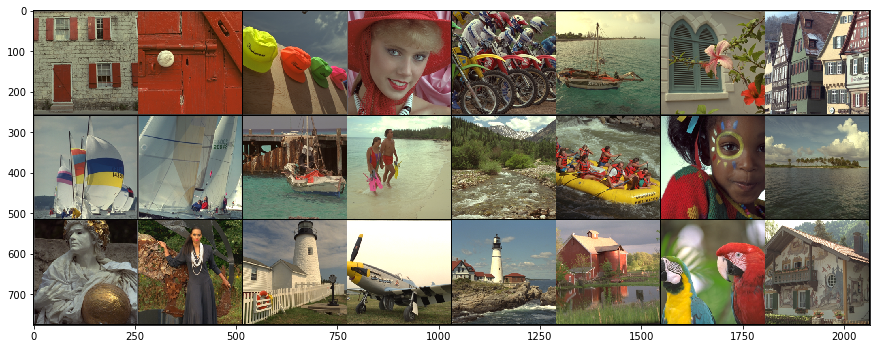

Noisy Kodak images:


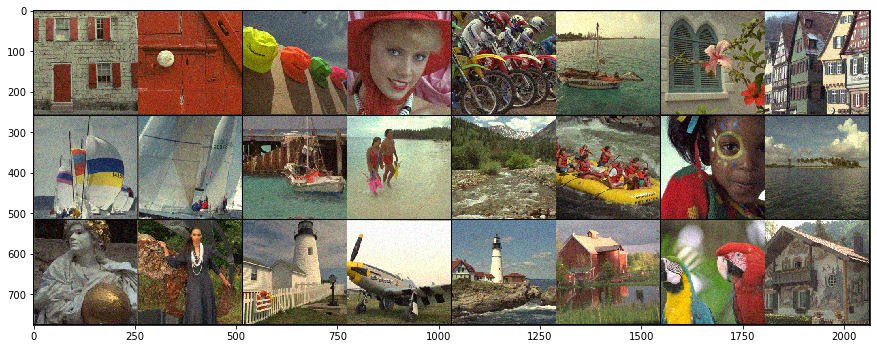

Reconstructed Kodak images:


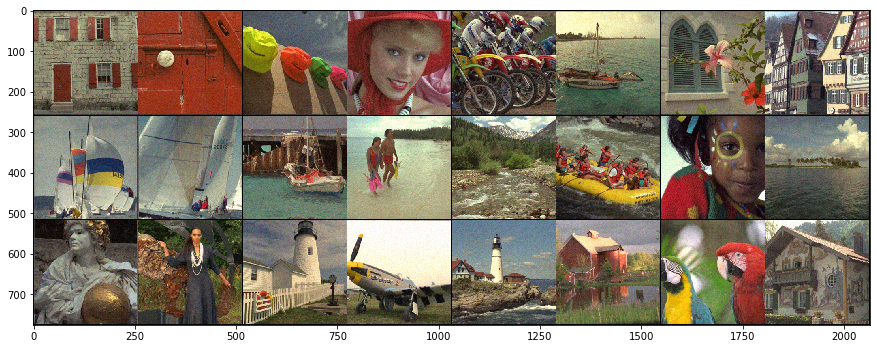

Kodak MSE loss: 0.0038028177805244923


In [15]:
# Validate with Kodak
kodak, _ = next(iter(kodak_loader))
noisy_kodak = image_noiser(kodak)
print("Original Kodak images:")
imgviz(kodak, save_fname='kodak_imgs.png', nrow=8)
print("Noisy Kodak images:")
imgviz(noisy_kodak, save_fname='noisy_kodak_imgs.png', nrow=8)
print("Reconstructed Kodak images:")
with torch.no_grad():
    kodak_preds = ae(noisy_kodak)
    imgviz(kodak_preds, save_fname='reconstruced_kodak_imgs.png', nrow=8)
    kodak_loss = F.mse_loss(kodak_preds, kodak)
    print('Kodak MSE loss:', kodak_loss.item())

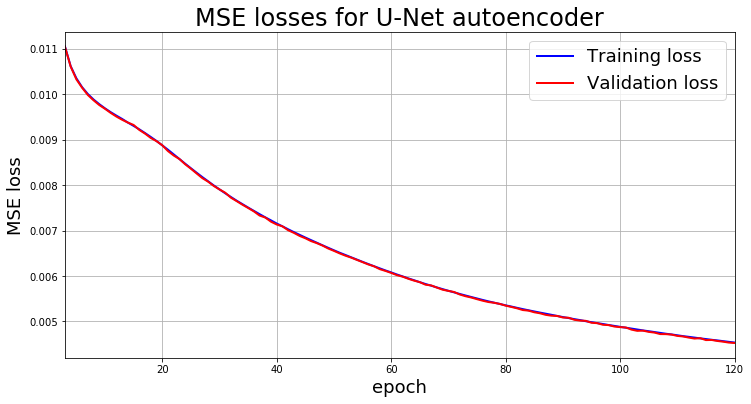

In [18]:
## Visualise losses in graph
train_losses = np.array([m.run.data[i]['train loss'] for i in range(2, len(m.run.data))])
val_losses = np.array([m.run.data[i]['validation loss'] for i in range(2, len(m.run.data))])
epochs = np.array(list(range(3, 121)))

figure = plt.figure(figsize=(12,6))
plt.plot(epochs, train_losses, 'b-', lw=2, label='Training loss')
plt.plot(epochs, val_losses, 'r-', lw=2, label='Validation loss')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('MSE loss', fontsize=18)
plt.title('MSE losses for U-Net autoencoder', fontsize=24)
plt.xlim([3,120])
plt.legend(fontsize=18)
plt.grid('on')
plt.savefig('./losses')
plt.show()